In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from FBSNNs import *
from BlackScholesBarenblatt100D import *

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 100  # number of trajectories (batch size)
N = 50  # number of time snapshots
D = 100 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 4 * [256] + [1]

Xi = np.array([1.0, 0.5] * int(D / 2))[None, :]
T = 1.0

"Available architectures"
mode = "NAIS-Net"  # FC, Resnet and NAIS-Net are available
activation = "Sine"  # Sine and ReLU are available
model = BlackScholesBarenblatt(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10**4
lr = 1e-3

In [4]:
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 0, Loss: 5.345e+05, Y0: 0.927, Time: 0.40, Learning Rate: 1.000e-03
It: 100, Loss: 5.104e+03, Y0: 74.606, Time: 1.47, Learning Rate: 1.000e-03
It: 200, Loss: 3.313e+03, Y0: 72.507, Time: 1.48, Learning Rate: 1.000e-03
It: 300, Loss: 2.217e+03, Y0: 77.673, Time: 1.51, Learning Rate: 1.000e-03
It: 400, Loss: 1.229e+03, Y0: 74.550, Time: 1.55, Learning Rate: 1.000e-03
It: 500, Loss: 1.294e+03, Y0: 77.619, Time: 1.46, Learning Rate: 1.000e-03
It: 600, Loss: 8.996e+02, Y0: 75.655, Time: 1.47, Learning Rate: 1.000e-03
It: 700, Loss: 7.996e+02, Y0: 74.301, Time: 1.49, Learning Rate: 1.000e-03
It: 800, Loss: 4.699e+02, Y0: 75.455, Time: 1.47, Learning Rate: 1.000e-03
It: 900, Loss: 6.914e+02, Y0: 77.592, Time: 1.48, Learning Rate: 1.000e-03
It: 1000, Loss: 4.515e+02, Y0: 75.116, Time: 1.49, Learning Rate: 1.000e-03
It: 1100, Loss: 5.288e+02, Y0: 76.887, Time: 1.47, Learning Rate: 1.000e-03
It: 1200, Loss: 3.567e+02, Y0: 74.842, Time: 1.55, Learning Rate: 1.000e-03
It: 1300, Loss: 3.

In [5]:
np.random.seed(42)
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)
samples = 5

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

Y_test = np.reshape(u_exact(T,np.reshape(t_test[0:M, :, :], [-1, 1]), np.reshape(X_pred[0:M, :, :], [-1, D])),
                    [M, -1, 1])

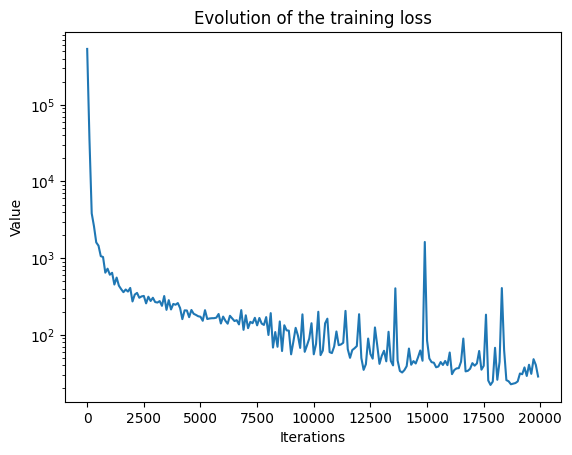

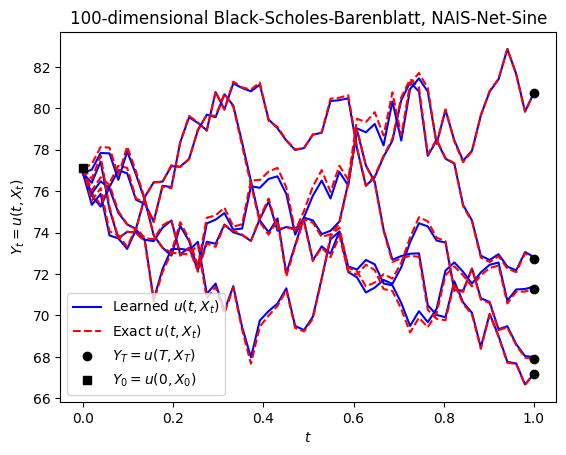

In [6]:
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')

plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, 'b', label='Learned $u(t,X_t)$')
plt.plot(t_test[0:1, :, 0].T, Y_test[0:1, :, 0].T, 'r--', label='Exact $u(t,X_t)$')
plt.plot(t_test[0:1, -1, 0], Y_test[0:1, -1, 0], 'ko', label='$Y_T = u(T,X_T)$')

plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T, 'b')
plt.plot(t_test[1:samples, :, 0].T, Y_test[1:samples, :, 0].T, 'r--')
plt.plot(t_test[1:samples, -1, 0], Y_test[1:samples, -1, 0], 'ko')

plt.plot([0], Y_test[0, 0, 0], 'ks', label='$Y_0 = u(0,X_0)$')

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()

plt.show()

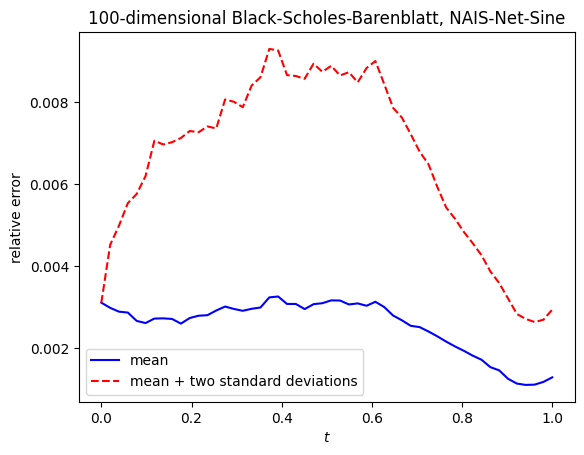

In [7]:
errors = np.sqrt((Y_test - Y_pred) ** 2 / Y_test ** 2)
mean_errors = np.mean(errors, 0)
std_errors = np.std(errors, 0)

plt.figure()
plt.plot(t_test[0, :, 0], mean_errors, 'b', label='mean')
plt.plot(t_test[0, :, 0], mean_errors + 2 * std_errors, 'r--', label='mean + two standard deviations')
plt.xlabel('$t$')
plt.ylabel('relative error')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()
plt.show()

In [8]:
model.save_model("models/BlackScholesBarenblattMLMC100D.pth")